In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Conv2D, MaxPooling2D, Activation, concatenate
# Import SqueezeNet from the keras_squeezenet library
# from keras_squeezenet import SqueezeNet
# Use preprocess_input from ResNet50 as it's a common ImageNet preprocessing
from tensorflow.keras.applications.resnet50 import preprocess_input 
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [2]:
# === CONFIG ===
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BASE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_DATASET_F1"
CLASSES = ["BLIGHT", "BLAST", "BROWNSPOT", "HEALTHY"]
IMG_SIZE = (224, 224) # SqueezeNet also typically uses 224x224
BATCH_SIZE = 32
EPOCHS = 1
LEARNING_RATE = 1e-5 # Slightly higher LR for initial training of new layers

In [3]:
def fire_module(x, squeeze_filters, expand_filters):
    squeeze = Conv2D(squeeze_filters, (1, 1), padding='valid', activation='relu')(x)

    expand_1x1 = Conv2D(expand_filters, (1, 1), padding='valid', activation='relu')(squeeze)
    expand_3x3 = Conv2D(expand_filters, (3, 3), padding='same', activation='relu')(squeeze)

    return concatenate([expand_1x1, expand_3x3], axis=-1)

def SqueezeNet(input_shape=(224, 224, 3), classes=1000):
    input_img = Input(shape=input_shape)
    x = Conv2D(96, (7, 7), strides=(2, 2), padding='valid', activation='relu')(input_img)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 64, 256)
    x = Conv2D(classes, (1, 1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax')(x)

    model = Model(inputs=input_img, outputs=x)
    return model

In [4]:
# === Load filepaths & labels ===
all_filepaths, all_labels = [], []
for idx, class_name in enumerate(CLASSES):
    aug_path = os.path.join(BASE_PATH, class_name, "augmented")
    files = glob.glob(os.path.join(aug_path, "*.jpg")) + \
            glob.glob(os.path.join(aug_path, "*.jpeg")) + \
            glob.glob(os.path.join(aug_path, "*.png"))
    all_filepaths.extend(files)
    all_labels.extend([idx] * len(files))

print(f"✅ Total images found: {len(all_filepaths)}")

✅ Total images found: 32460


In [5]:
# === tf.data.Dataset ===
filepaths_ds = tf.data.Dataset.from_tensor_slices(all_filepaths)
labels_ds = tf.data.Dataset.from_tensor_slices(all_labels)
ds = tf.data.Dataset.zip((filepaths_ds, labels_ds)).shuffle(len(all_filepaths), seed=SEED)

train_size = int(0.8 * len(all_filepaths))
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)

print(f"✅ Train samples: {train_size} | Val samples: {len(all_filepaths) - train_size}")

✅ Train samples: 25968 | Val samples: 6492


In [6]:
# === Color Jitter ===
def color_jitter(image):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.05)
    return tf.clip_by_value(image, 0.0, 255.0)

# === GridMask ===
def grid_mask(image, d_min=50, d_max=100, ratio=0.5):
    h, w, _ = image.shape
    d = tf.random.uniform([], d_min, d_max, dtype=tf.int32)
    l = tf.cast(tf.cast(d, tf.float32) * ratio, tf.int32)

    mask = tf.ones([h, w], dtype=tf.float32)

    for i in range(0, h, d):
        for j in range(0, w, d):
            y1 = i
            y2 = tf.minimum(i + l, h)
            x1 = j
            x2 = tf.minimum(j + l, w)

            y_range = tf.range(y1, y2)
            x_range = tf.range(x1, x2)
            yy, xx = tf.meshgrid(y_range, x_range, indexing='ij')
            indices = tf.stack([yy, xx], axis=-1)
            indices = tf.reshape(indices, [-1, 2])

            mask = tf.tensor_scatter_nd_update(
                mask,
                indices,
                tf.zeros([(y2 - y1) * (x2 - x1)], dtype=tf.float32)
            )

    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.tile(mask, [1, 1, 3])
    return image * mask

# === Image Processor ===
def process_img(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    img = color_jitter(img)
    img = grid_mask(img)

    # Use the same preprocess_input as ResNet50, which works for ImageNet pre-trained models
    img = preprocess_input(img) 

    label = tf.one_hot(label, depth=len(CLASSES))
    return img, label

# # === CutMix ===
# def cutmix(images, labels, alpha=1.0):
#     batch_size = tf.shape(images)[0]
#     img_h = tf.shape(images)[1]
#     img_w = tf.shape(images)[2]

#     lam = tfp.distributions.Beta(alpha, alpha).sample([batch_size])

#     rand_idx = tf.random.shuffle(tf.range(batch_size))
#     images2 = tf.gather(images, rand_idx)
#     labels2 = tf.gather(labels, rand_idx)

#     cut_rat = tf.math.sqrt(1. - lam)
#     cut_w = tf.cast(img_w, tf.float32) * cut_rat
#     cut_h = tf.cast(img_h, tf.float32) * cut_rat

#     cx = tf.random.uniform([batch_size], 0, tf.cast(img_w, tf.float32))
#     cy = tf.random.uniform([batch_size], 0, tf.cast(img_h, tf.float32))

#     x1 = tf.cast(cx - cut_w / 2, tf.int32)
#     y1 = tf.cast(cy - cut_h / 2, tf.int32)
#     x2 = tf.cast(cx + cut_w / 2, tf.int32)
#     y2 = tf.cast(cy + cut_h / 2, tf.int32)

#     x1 = tf.clip_by_value(x1, 0, img_w)
#     y1 = tf.clip_by_value(y1, 0, img_h)
#     x2 = tf.clip_by_value(x2, 0, img_w)
#     y2 = tf.clip_by_value(y2, 0, img_h)

#     def apply_cutmix(i):
#         img1 = images[i]
#         img2 = images2[i]
#         bbx1, bby1, bbx2, bby2 = x1[i], y1[i], x2[i], y2[i]

#         mask = tf.pad(
#             tf.zeros([bby2 - bby1, bbx2 - bbx1, 3]),
#             [[bby1, img_h - bby2],
#              [bbx1, img_w - bbx2],
#              [0, 0]],
#             constant_values=1.0
#         )
#         mask = 1.0 - mask
#         mixed = img1 * mask + img2 * (1.0 - mask)

#         area = tf.cast(bbx2 - bbx1, tf.float32) * tf.cast(bby2 - bby1, tf.float32)
#         lam_adjusted = 1.0 - (area / tf.cast(img_w * img_h, tf.float32))
#         new_label = lam_adjusted * labels[i] + (1.0 - lam_adjusted) * labels2[i]

#         return mixed, new_label

#     mixed_images, mixed_labels = tf.map_fn(
#         apply_cutmix,
#         tf.range(batch_size),
#         fn_output_signature=(tf.float32, tf.float32)
#     )

#     return mixed_images, mixed_labels

In [7]:
# === Final Pipeline ===
train_ds = train_ds.map(process_img).batch(BATCH_SIZE)
# train_ds = train_ds.map(lambda x, y: cutmix(x, y)).prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_img).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
# === SqueezeNet Model ===
# Load SqueezeNet v1.1 with ImageNet weights
base_model = SqueezeNet(input_shape=(224, 224, 3) , classes=len(CLASSES))

# Freeze all layers in the base model for feature extraction
for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))
# SqueezeNet does not have explicit BatchNormalization layers at the end that would be affected by 'training=False'
# like ResNet50. However, if any BN layers are present in the backbone, keeping training=False is generally safe
# for feature extraction to use population statistics.
x = base_model(inputs) 
# x = GlobalAveragePooling2D()(x)   # Already done in SqueezeNet function
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(len(CLASSES), activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# === Learning rate logger ===
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, '__call__'):
            lr = lr(self.model.optimizer.iterations)
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f"📉 Learning rate at epoch {epoch+1}: {lr:.6f}")

# === Compute class weights ===
y_train_int = np.argmax(np.concatenate([labels.numpy() for _, labels in train_ds.unbatch().batch(BATCH_SIZE)]), axis=1)
class_weights = dict(enumerate(class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(CLASSES)),
    y=y_train_int
)))
print("✅ Computed class weights:", class_weights)

✅ Computed class weights: {0: 0.9976947902259106, 1: 1.0065116279069768, 2: 0.9925087907047851, 3: 1.003400309119011}


In [10]:
# === Train ===
print("\n🚀 Starting SqueezeNet Phase 1 Training (Feature Extraction)...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True), LearningRateLogger()],
    class_weight=class_weights
)


🚀 Starting SqueezeNet Phase 1 Training (Feature Extraction)...
📉 Learning rate at epoch 1: 0.000010==] - ETA: 0s - loss: 1.3866 - accuracy: 0.2487     
812/812 [==============================] - 165s 194ms/step - loss: 1.3866 - accuracy: 0.2487 - val_loss: 1.3863 - val_accuracy: 0.2465


1/1 [==============================] - 0s 24ms/step

📊 Classification Report:
              precision    recall  f1-score   support

      BLIGHT       0.00      0.00      0.00      1638
       BLAST       0.25      1.00      0.39      1592
   BROWNSPOT       0.00      0.00      0.00      1592
     HEALTHY       0.00      0.00      0.00      1670

    accuracy                           0.25      6492
   macro avg       0.06      0.25      0.10      6492
weighted avg       0.06      0.25      0.10      6492



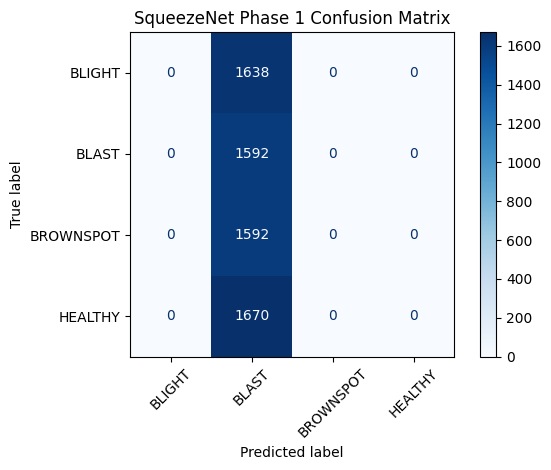

✅ SqueezeNet Phase 1 Model saved at: C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_MODEL\SqueezeNet_Phase1_try.h5


In [12]:
# === Evaluate ===
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=CLASSES).plot(cmap="Blues", xticks_rotation=45)
plt.title("SqueezeNet Phase 1 Confusion Matrix")
plt.tight_layout()
plt.show()

# === Save ===
# SAVE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_MODEL\SqueezeNet_Phase1_CutMix_GridMask.h5"
# SAVE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_MODEL\SqueezeNet_Phase1_GridMask.h5"
SAVE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_MODEL\SqueezeNet_Phase1_try.h5"
model.save(SAVE_PATH)
print(f"✅ SqueezeNet Phase 1 Model saved at: {SAVE_PATH}")